In [9]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Investigation Overview

> [Bay Wheels](https://en.wikipedia.org/wiki/Bay_Wheels) (previously known as Ford GoBike) is a regional public bike sharing system in the San Francisco Bay Area, California. Bay Wheels is the first regional and large-scale bicycle sharing system deployed in California and on the West Coast of the United States with nearly 500,000 rides since the launch in 2017 and had about 10,000 annual subscribers as of January 2018. This exploration and visualization study primarily focuses on finding the bike usage pattern and customer habit characteristics from the 12-month ride trips data in 2018.  

## Dataset Overview

> The dataset used for this exploratory analysis consists of [monthly individual trip data](https://www.lyft.com/bikes/bay-wheels/system-data) from January 2018 to December 2018 in CSV format covering the greater San Francisco Bay area, raw data is available [here](https://s3.amazonaws.com/baywheels-data/index.html). Visualizations below are created from wrangled and cleaned data to facilitate exploration analysis and help discover usage pattern and rider characteristics.

In [10]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [11]:
# load in the dataset into a pandas dataframe and clean up field dtypes
trips18 = pd.read_csv('fordgobike_trips_2018_clean.csv')

trips18['start_time'] = pd.to_datetime(trips18['start_time'])
trips18['end_time'] = pd.to_datetime(trips18['end_time'])

trips18['start_station_id'] = trips18['start_station_id'].astype('str')
trips18['end_station_id'] = trips18['end_station_id'].astype('str')
trips18['bike_id'] = trips18['bike_id'].astype('str')

trips18['user_type'] = trips18['user_type'].astype('category')
trips18['member_gender'] = trips18['member_gender'].astype('category')

weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekdaycat = pd.api.types.CategoricalDtype(ordered=True, categories=weekday)
trips18['start_dayofweek'] = trips18['start_dayofweek'].astype(weekdaycat)

month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthcat = pd.api.types.CategoricalDtype(ordered=True, categories=month)
trips18['start_month'] = trips18['start_month'].astype(monthcat)

trips18.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688410 entries, 0 to 1688409
Data columns (total 26 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   duration_sec             1688410 non-null  int64         
 1   start_time               1688410 non-null  datetime64[ns]
 2   end_time                 1688410 non-null  datetime64[ns]
 3   start_station_id         1688410 non-null  object        
 4   start_station_name       1688410 non-null  object        
 5   start_station_latitude   1688410 non-null  float64       
 6   start_station_longitude  1688410 non-null  float64       
 7   end_station_id           1688410 non-null  object        
 8   end_station_name         1688410 non-null  object        
 9   end_station_latitude     1688410 non-null  float64       
 10  end_station_longitude    1688410 non-null  float64       
 11  bike_id                  1688410 non-null  object        
 12  

## User Types by Age Group

> user's subscription ratio increases as the age increase. Younger user tend to use the service but do not subscribe.

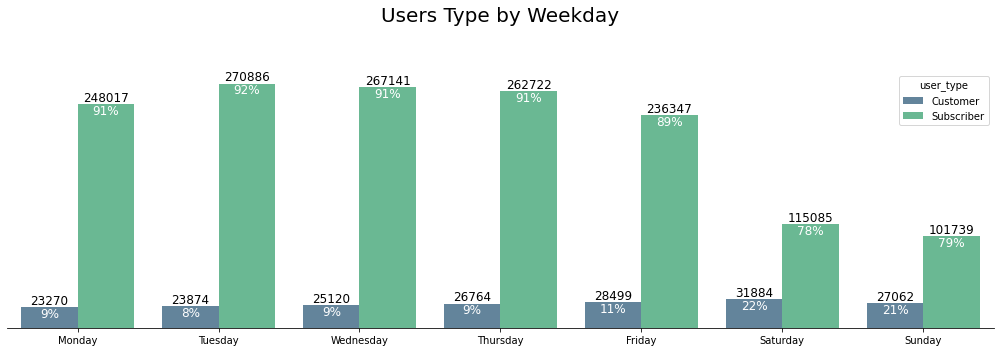

In [12]:
fig, ax = plt.subplots(figsize = (14,5))
# Plotting
sb.countplot(x = "start_dayofweek", data = trips18, 
              palette = "viridis", hue = "user_type", alpha = 0.8)

# Percentage for each day
perc_list_customer, perc_list_subscriber, perc_list = [], [], []

# Calculate % for 2 user types for each day
type_sum = trips18.groupby('start_dayofweek')['user_type'].value_counts().sort_index().to_list()
total_sum = trips18['start_dayofweek'].value_counts().sort_index().to_list()

# arrange the % list in same as annotate loop order
for i in range(0,len(total_sum)):
    perc_customer = int(round(100 * type_sum[2*i] / total_sum[i]))
    perc_list_customer.append(perc_customer)
for i in range(0,len(total_sum)):
    perc_subscriber = int(round(100 * type_sum[2*i+1]/ total_sum[i]))
    perc_list_subscriber.append(perc_subscriber)
perc_list = perc_list_customer + perc_list_subscriber

# Annotate each bar
i=0
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), 
                (p.get_x()+p.get_width()/2, p.get_height()), 
                ha="center", va="bottom", size=12)
    ax.annotate('{:.0f}%'.format(perc_list[i]), 
                (p.get_x()+p.get_width()/2, p.get_height()), 
                ha="center", va="top", color='white', size=12)
    i+=1

# Aesthetic wrangling
cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)
sb.despine(fig, left = True)
plt.title("Users Type by Weekday\n\n", fontsize= 20)
plt.xlabel("")
plt.tight_layout();

## Hourly Usage during Weekdays for Customers and Subscribers

> Different usage patterns/habits between the two types of riders are clearly seen. Subscribers used the system heavily on work days i.e. Monday through Friday, whereas customers ride a lot on weekends, especially in the afternoon. Many trips concentrated around 8-9am and 17-18pm on work days for subscribers when used for work commute, yet casual customers tended to use more in the late afternoon around 17pm Monday to Friday. Other than the different usage goals, it may also have to do with the traffic situation around these rush hours in the area.  

<Figure size 432x288 with 0 Axes>

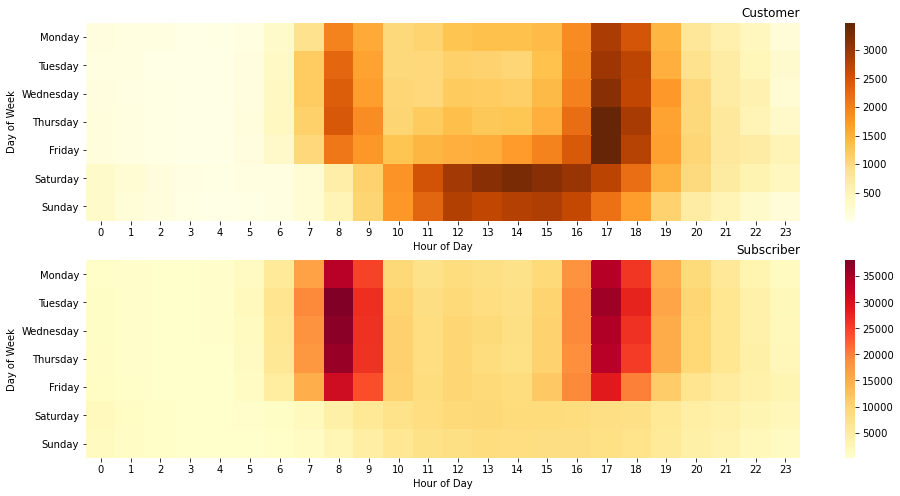

In [13]:
plt.suptitle('Hourly Usage during Weekdays for Customers and Subscribers');
#fig, ax = plt.subplots(figsize=(5,5)) 

plt.figure(figsize = (16,8));
plt.subplot(2, 1, 1);
customers = trips18.query('user_type == "Customer"');
ct_counts = customers.groupby(['start_dayofweek', 'start_hourofday']).size();
ct_counts = ct_counts.reset_index(name='count');
ct_counts = ct_counts.pivot(index='start_dayofweek', columns='start_hourofday', values='count');
sb.heatmap(ct_counts, cmap='YlOrBr');
plt.title('Customer', loc='right');
plt.xlabel('Hour of Day');
plt.ylabel('Day of Week');

plt.subplot(2, 1, 2);
subscribers = trips18.query('user_type == "Subscriber"');
st_counts = subscribers.groupby(['start_dayofweek', 'start_hourofday']).size();
st_counts = st_counts.reset_index(name='count');
st_counts = st_counts.pivot(index='start_dayofweek', columns='start_hourofday', values='count');
sb.heatmap(st_counts, cmap='YlOrRd');
plt.title('Subscriber', loc='right');
plt.xlabel('Hour of Day');
plt.ylabel('Day of Week');

## Average Weekday Trip Duration for Customers and Subscribers

> Subscribers ride much shorter/quicker trips compared to customers on each day of the week. Both user types had an obvious increase of trip duration on Saturdays and Sundays (or weekends), especially casual customers. Subscriber usage was more efficient than customers overall and maintained a pretty consistent average duration Monday through Friday.

**The East Bay age structure is broader than the one of San Francisco and San José has the youngest average group of users. The next plots will focus on time components of our data. What about trips per day?**

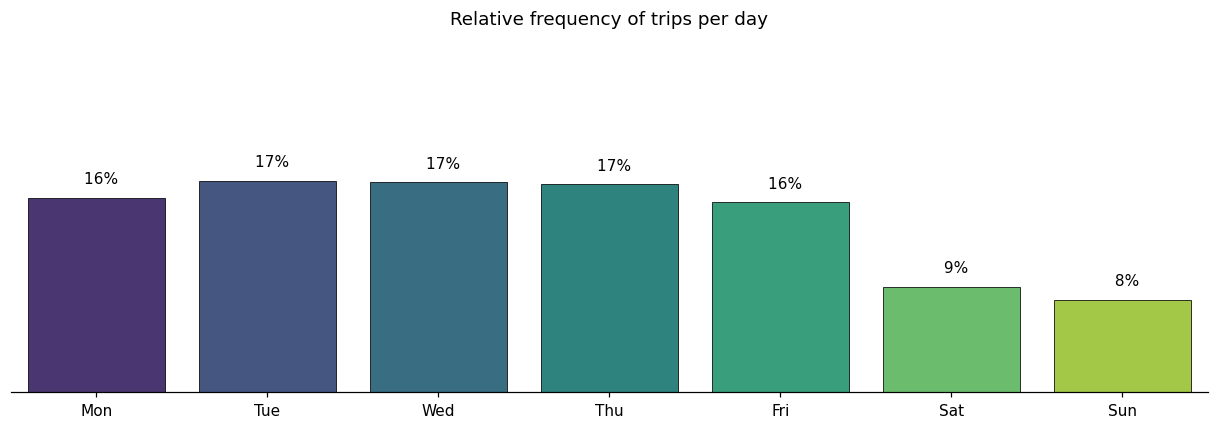

In [14]:
fig, ax = plt.subplots(figsize = (12,4), dpi = 110)
sb.countplot(x = "start_dayofweek", data = trips18, palette = "viridis", lw = 0.5, edgecolor = "black");

plt.tight_layout()
cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)
sb.despine(fig, left = True)
plt.title("Relative frequency of trips per day")
ax.set(xticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]);
plt.xlabel("")
plt.ylim(0,500000)
for p in ax.patches:
    ax.annotate('{:10.0f}%'.format(p.get_height()/len(trips18)*100), (p.get_x()+0.1, p.get_height()+20000))

**It looks like the users use the bikes more frequently during the week than during the weekend. And when do they start their trips?**

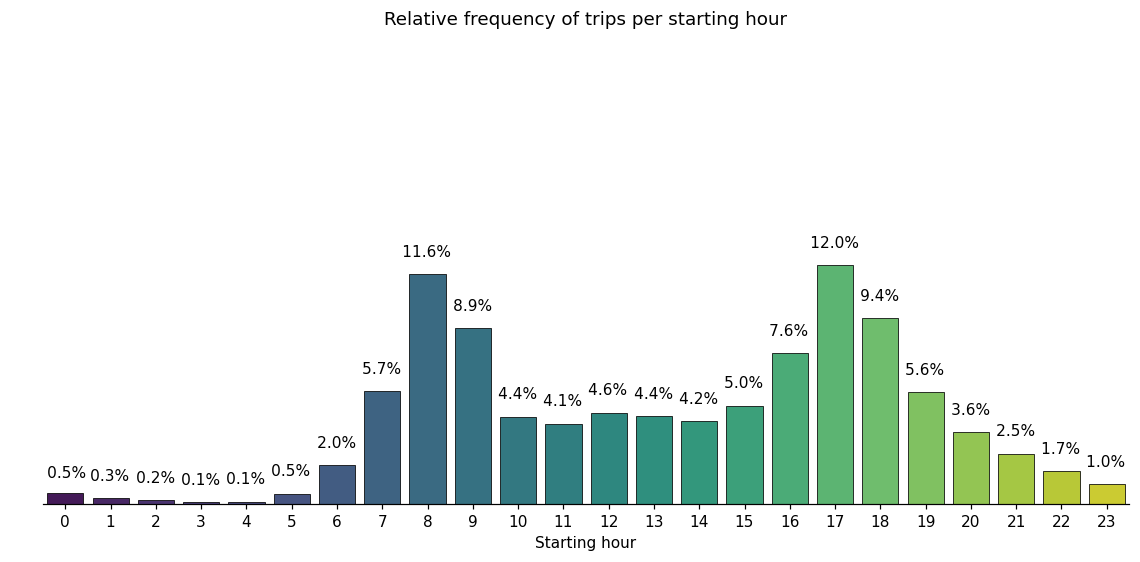

In [15]:
fig, ax = plt.subplots(figsize = (11,5), dpi = 110)

sb.countplot(x = "hour", data = trips18, palette = "viridis", ax = ax, lw = 0.5, edgecolor = "black");

plt.tight_layout()
cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)
sb.despine(fig, left = True)
plt.title("Relative frequency of trips per starting hour")
plt.xlabel("Starting hour")
plt.ylim(0,400000)
for p in ax.patches:
    ax.annotate('{:10.1f}%'.format(p.get_height()/len(trips18)*100), (p.get_x()-0.8,p.get_height()+15000))

ax.text(0-1.15, ax.patches[0].get_height()+13000, '{:10.1f}%'.format(ax.patches[0].get_height()/len(trips18)*100));

**The most frequent starting hours are at 8 and at 17. Maybe people use it before and after work, which would make sense, because we have a lot of subscribers in working age in our dataset. You only subscribe to something, if you want to use it regulary. The integration into the working/study life would make sense here!**

## Summary

> There was a lot more subscribers using the bike sharing system than casual customers overall, both of which ride the most during the summer season and the least during the winter months. Obviously different usage patterns and riding habits are observed between the two types of riders. Subscribers used the system heavily on work days concentrated around 8-9am and 17-18pm for work commute, whereas customers ride a lot over weekends and in the afternoon for leisure/touring purposes. Subscribers tended to have much shorter/quicker trips compared to customers which makes subscriber usage more efficient.